<a href="https://colab.research.google.com/github/SohamBera16/Image-Classification-with-CIFAR-10-dataset/blob/main/CIFAR_10_Image_Classifier_STARTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [11]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
from torchvision import models 
from torch.optim import lr_scheduler

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
# Reference: https://pytorch.org/tutorials/
## YOUR CODE HERE ##
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.RandomHorizontalFlip(p=0.5),transforms.RandomRotation(40),transforms.RandomCrop(32)])

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.RandomHorizontalFlip(p=0.5),transforms.RandomRotation(40),transforms.RandomCrop(32)])

# Create training set and testing set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
#splitting training and validation set with a 9:1 ratio
torch.manual_seed(42)          #for reproducibility of validation set
val_size = 5000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])
print(len(train_ds))
print(len(val_ds))

45000
5000


In [4]:
# define training and validation dataloader
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val_ds,batch_size = 256, shuffle = False, num_workers=2)

# define test dataloader
testloader = torch.utils.data.DataLoader(testset,  batch_size=256, shuffle=False, num_workers=2)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

50000
torch.Size([3, 32, 32])


cat


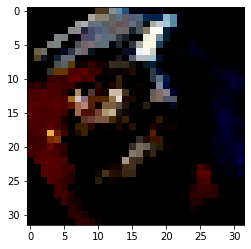

ship


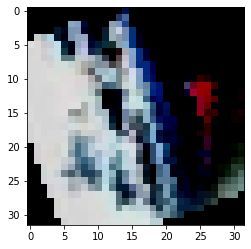

ship


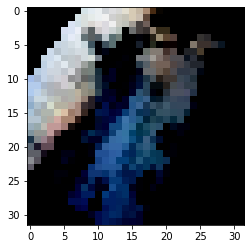

plane


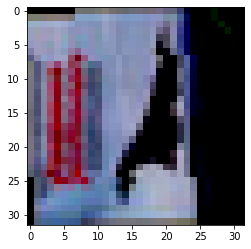

frog


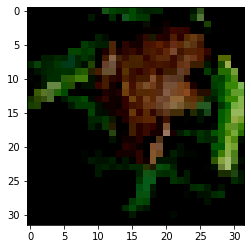

In [6]:
# Explore data
# size of the training data set
print(len(trainset))

#shape of the training dataset images
sample = next(iter(trainset))
image, label = sample
print(image.shape)

#print 5 images from the test dataset
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [38]:
# handcrafted CNN model
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = self.softmax(x)
    return x

model = Model()

# implementing Transfer Learning using resnet18 model
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
#model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 128),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(128, 10),
                              nn.LogSoftmax(dim=1))

model_conv = model_conv

In [54]:
# densenet model 

model_densenet = models.densenet121(pretrained=True)

for param in model_densenet.parameters():
    param.requires_grad = False
    
model_densenet.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 10),
                                 nn.LogSoftmax(dim=1))
model_densenet = model_densenet

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [55]:
# specifying loss function and optimizer 
criterion = nn.NLLLoss()
optimizer_densenet = optim.Adam(model_densenet.classifier.parameters(), lr=0.003)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [56]:
train_losses, val_losses = [], []
epochs = 10

for epoch in range(epochs): 

    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer_densenet.zero_grad()

        # forward + backward + optimize
        outputs = model_densenet.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_densenet.step()

        # print statistics
        running_loss += loss.item()
        train_losses.append(running_loss/len(trainloader))
        #exp_lr_scheduler.step()
        if i % 200 == 199:    # print for every 200 mini-batches
          val_loss = 0
          accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
          model_densenet.eval()
          with torch.no_grad():
            for images, labels in valloader:
                log_ps = model_densenet.forward(images)
                val_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
          train_losses.append(running_loss/len(trainloader))
          val_losses.append(val_loss/len(valloader))

          print("Epoch: {}/{}.. ".format(epoch+1, epochs),
                "Training Loss: {:.3f}.. ".format(running_loss/200),
                "Validation Loss: {:.3f}.. ".format(val_loss/len(valloader)),
                "Validation Accuracy: {:.3f}".format(accuracy/len(valloader)))
          
          running_loss = 0.0
          model_densenet.train()
          
print('Finished Training')

Epoch: 1/10..  Training Loss: 1.735..  Validation Loss: 1.586..  Validation Accuracy: 0.446
Epoch: 2/10..  Training Loss: 1.557..  Validation Loss: 1.518..  Validation Accuracy: 0.469
Epoch: 3/10..  Training Loss: 1.531..  Validation Loss: 1.470..  Validation Accuracy: 0.484
Epoch: 4/10..  Training Loss: 1.501..  Validation Loss: 1.459..  Validation Accuracy: 0.480
Epoch: 5/10..  Training Loss: 1.488..  Validation Loss: 1.452..  Validation Accuracy: 0.481
Epoch: 6/10..  Training Loss: 1.475..  Validation Loss: 1.456..  Validation Accuracy: 0.480
Epoch: 7/10..  Training Loss: 1.473..  Validation Loss: 1.430..  Validation Accuracy: 0.489
Epoch: 8/10..  Training Loss: 1.457..  Validation Loss: 1.441..  Validation Accuracy: 0.484
Epoch: 9/10..  Training Loss: 1.456..  Validation Loss: 1.410..  Validation Accuracy: 0.502
Epoch: 10/10..  Training Loss: 1.445..  Validation Loss: 1.413..  Validation Accuracy: 0.505
Finished Training


Plot the training loss (and validation loss/accuracy, if recorded).

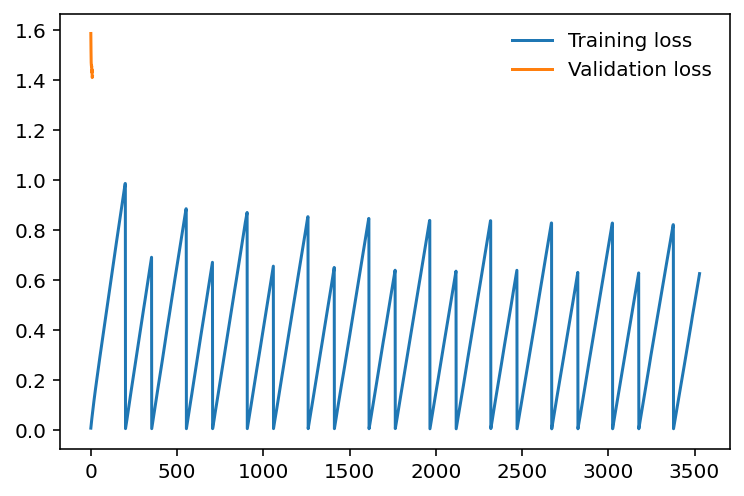

In [63]:
## YOUR CODE HERE ##
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Param_range = np.arange(1,10)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [64]:
## YOUR CODE HERE ##
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model_densenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 47 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [65]:
# handcrafted CNN model
# PATH = './cifar_model.pth'
# torch.save(model.state_dict(), PATH)  # accuracy = 37%

# Resnet18 model
# PATH = './cifar_resnet18_model.pth'
# torch.save(model_conv.state_dict(), PATH) # accuracy: 38%

# densenet121 model
PATH = './cifar_densenet121_model.pth'
torch.save(model_densenet.state_dict(), PATH) # accuracy: 47%

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Based on the performance of the best performing created model as well as the other model performances, the recommendation would be to go ahead with Detectocorp's algorithm which provides 70% accuracy. 

But, an important thing to consider here would be that the algorithms were tested on a CPU based machine which is comparatively less computationally powerful than computers with GPU acceleration capability and as the state-of-the-art, open source models does perform extremely well in the CIFAR-10 dataset, if accuracy score on this particular dataset is the only benchmark to consider, then we should definitely save the cost by using the cutting edge models along with fine-tuning steps as tested in this project which will surely provide a much better result than Detectocorp's algorithm.

Hence, investment in purchasing either some GPU accelerated machines or cloud based GPU powered backend servers would be the best possible recommendation for my company in my opinion. 



